DSL Autumn Call - Sentiment Analysis 

In [1]:
# Library
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from nltk.tokenize import TweetTokenizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.model_selection import learning_curve


# Function to process the dataframe
def preprocess_dataframe(df, ohe_day=None):
    # Remove column "flag" from the dataset
    df_preprocessed = df.drop(columns=['flag'])
    
    # Dictionary for replacing special characters
    substitutions = {
        '&quot;': '"',
        '&amp;': '&',
        '&gt;': '>',
        '&lt;': '<',
    }
    
    # Emoticons to be replaced with text descriptions (opensource code)
    EMOTICONS_EMO = {
    ':‑)': 'Happy face or smiley',
    ':)': 'Happy face or smiley',
    ':))': 'Very Happy face or smiley',
    ':)))': 'Very very Happy face or smiley',
    ':]': 'Happy face or smiley',
    ':3': 'Happy face smiley',
    ':->': 'Happy face smiley',
    ':>': 'Happy face smiley',
    ':o)': 'Happy face smiley',
    ':}': 'Happy face smiley',
    ':c)': 'Happy face smiley',
    ':^)': 'Happy face smiley',
    '=]': 'Happy face smiley',
    '=)': 'Happy face smiley',
    ':‑D': 'Laughing, big grin or laugh with glasses',
    ':D': 'Laughing, big grin or laugh with glasses',
    '8‑D': 'Laughing, big grin or laugh with glasses',
    '8D': 'Laughing, big grin or laugh with glasses',
    'X‑D': 'Laughing, big grin or laugh with glasses',
    'XD': 'Laughing, big grin or laugh with glasses',
    '=D': 'Laughing, big grin or laugh with glasses',
    '=3': 'Laughing, big grin or laugh with glasses',
    ':‑(': 'Frown, sad, andry or pouting',
    ':(': 'Frown, sad, andry or pouting',
    ':‑c': 'Frown, sad, andry or pouting',
    ':c': 'Frown, sad, andry or pouting',
    ':‑<': 'Frown, sad, andry or pouting',
    ':<': 'Frown, sad, andry or pouting',
    ':‑[': 'Frown, sad, andry or pouting',
    ':[': 'Frown, sad, andry or pouting',
    ":'‑(": 'Crying',
    ":'(": 'Crying',
    ":'‑)": 'Tears of happiness',
    ":')": 'Tears of happiness',
    ':‑O': 'Surprise',
    ':O': 'Surprise',
    ':‑o': 'Surprise',
    ':o': 'Surprise',
    ';‑)': 'Wink or smirk',
    ';)': 'Wink or smirk',
    ':P': 'Tongue sticking out, cheeky, playful or blowing a raspberry',
    ':‑Þ': 'Tongue sticking out, cheeky, playful or blowing a raspberry',
    ':Þ': 'Tongue sticking out, cheeky, playful or blowing a raspberry',
    ':b': 'Tongue sticking out, cheeky, playful or blowing a raspberry',
    ':‑|': 'Straight face',
    ':|': 'Straight face',
    ':$': 'Embarrassed or blushing',
    ':L': 'Skeptical, annoyed, undecided',
    ':S': 'Skeptical, confused'
    }
    
    # Apply substitutions
    for abbr, full_form in substitutions.items():
        df_preprocessed['text'] = df_preprocessed['text'].str.replace(abbr, full_form, regex=False)

    # Apply substitutions of emoticons
    for emoticon, description in EMOTICONS_EMO.items():
        df_preprocessed['text'] = df_preprocessed['text'].str.replace(emoticon, description, regex=False)
    
    # Tweet length Calculation
    # tweet_length = df_preprocessed['text'].str.len()
    
    # Removing links
    link_regex = r'(?:www\.|https?://)\S+'
    contains_links = df_preprocessed['text'].apply(lambda x: bool(re.search(link_regex, x)))
    df_preprocessed['text'] = df_preprocessed['text'].apply(lambda x: re.sub(link_regex, '', x))
    
    # Removing hashtag
    hashtag_regex = r'#\w+'
    df_preprocessed['text'] = df_preprocessed['text'].str.replace(hashtag_regex, '', regex=True)
    
    # Mentions count
    mention_regex = r'@\w+'
    contains_mentions = df_preprocessed['text'].str.contains(mention_regex)
    
    # Removing mentions
    df_preprocessed['text'] = df_preprocessed['text'].str.replace(mention_regex, '', regex=True)
    
    # Text tokenization
    print("Tokenizing...")
    tokenized_tweets = []
    tokenizer = TweetTokenizer()
    for tweet in df_preprocessed['text']:
        tokens = tokenizer.tokenize(tweet)
        filtered_tweet = []
        for word in tokens:
            word = re.sub(r'(.)\1{2,}', r'\1\1', word.strip().lower())
            if (word.isalnum() or "'" in word) and len(word) > 1:
                filtered_tweet.append(word)
        tokenized_tweets.append(filtered_tweet)
    
    df_preprocessed['filtered_text'] = [" ".join(map(str, l)) for l in tokenized_tweets]

    # Add user information
    df_preprocessed['filtered_text'] = df_preprocessed['filtered_text'] + " " + df['user']
    
    # Parsing day and hour
    df_preprocessed['day'] = [date[0] for date in df_preprocessed['date'].str.split()]
    df_preprocessed['hour'] = [int(date[3].split(':')[0]) for date in df_preprocessed['date'].str.split()]
    
    # Encoding Days with OneHotEncoder
    if ohe_day is None:
        ohe_day = OneHotEncoder(sparse_output=False, dtype=int)
        day_encoded = ohe_day.fit_transform(df_preprocessed[['day']])
    else:
        day_encoded = ohe_day.transform(df_preprocessed[['day']])
    
    day_columns = [f'day_{i}' for i in range(day_encoded.shape[1])]
    
    df_preprocessed = df_preprocessed.drop(columns=['date', 'day'])
    df_preprocessed = pd.concat([df_preprocessed, pd.DataFrame(day_encoded, columns=day_columns)], axis=1)
    

    # df_preprocessed['length'] = tweet_length
    df_preprocessed['contains_links'] = list(map(int, contains_links))
    df_preprocessed['contains_mentions'] = list(map(int, contains_mentions))

    return df_preprocessed, ohe_day

# Load development data
print("Loading and preprocessing development data...")
df_dev = pd.read_csv('development.csv')
df_preprocessed, ohe_day = preprocess_dataframe(df_dev)

# Remove duplicates based on 'ids'
print("Removing duplicates based on 'ids'")
df_preprocessed = df_preprocessed.drop_duplicates(subset=['ids'], keep='first')

# Creating the final set
X = df_preprocessed[['filtered_text', 'contains_links', 'contains_mentions', 'hour'] + [col for col in df_preprocessed.columns if col.startswith('day_')]]
y = df_preprocessed['sentiment']

# Pipeline
pipeline = Pipeline([
    ('features', ColumnTransformer([
        ('text', TfidfVectorizer(), 'filtered_text'),
        ('additional', 'passthrough', ['contains_links', 'contains_mentions', 'hour']),
        ('day', 'passthrough', [col for col in X.columns if col.startswith('day_')])
    ])),
    ('classifier', LinearSVC(class_weight='balanced', max_iter=10000, dual=False))
    # ('classifier', RandomForestClassifier(random_state=42))
])


# Hyperparameter tuning with RandomizedSearchCV
param_distributions = {
    'features__text__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'features__text__max_df': [0.1, 0.2, 0.5],
    'features__text__min_df': [2, 5, 10],
    'features__text__max_features': [5000, 10000, 15000],
    'classifier__C': np.linspace(0.1, 1.0, 20), # np.linspace(0.1, 1.0, 20) np.logspace(-3, 0, 10)
    'classifier__penalty' : ['l2']
}

# Stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='f1_macro',
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Model training
print("Fitting the model...")
random_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters:", random_search.best_params_)

# Evaluation on training data
y_pred_train = random_search.best_estimator_.predict(X_train)
train_f1 = f1_score(y_train, y_pred_train, average='macro')
print(f"F1 Score on training set: {train_f1:.4f}")

# Evaluation on test data
y_pred_test = random_search.best_estimator_.predict(X_test)
test_f1 = f1_score(y_test, y_pred_test, average='macro')
print(f"F1 Score on test set: {test_f1:.4f}")

print(f"Difference between training and test F1 Score: {train_f1 - test_f1:.4f}")

# ----------------------------------------------------------------------------------------------------------

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

# plot_confusion_matrix(y_test, y_pred_test, classes=np.unique(y_test))

# ----------------------------------------------------------------------------------------------------------

# Load evaluation data
print("Loading and preprocessing evaluation data...")
df_eval = pd.read_csv('evaluation.csv')
df_eval_preprocessed, _ = preprocess_dataframe(df_eval, ohe_day)

# Prepare evaluation data in the same format as training data
X_eval = df_eval_preprocessed[['filtered_text', 'contains_links', 'contains_mentions', 'hour'] + [col for col in df_eval_preprocessed.columns if col.startswith('day_')]]

# Valuation data predictions
y_pred_eval = random_search.best_estimator_.predict(X_eval)

# Prepare the submission file
submission = pd.DataFrame({
    'Id': df_eval['ids'],
    'Predicted': y_pred_eval
})

submission.to_csv('submission.csv', index=False)

print("Submission file created: submission.csv")

Loading and preprocessing development data...
Tokenizing...
Removing duplicates based on 'ids'
Fitting the model...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'features__text__ngram_range': (1, 1), 'features__text__min_df': 2, 'features__text__max_features': 15000, 'features__text__max_df': 0.2, 'classifier__penalty': 'l2', 'classifier__C': 0.33684210526315794}
F1 Score on training set: 0.8530
F1 Score on test set: 0.8110
Difference between training and test F1 Score: 0.0421
Loading and preprocessing evaluation data...
Tokenizing...
Submission file created: submission.csv


WordCloud of most frequent words

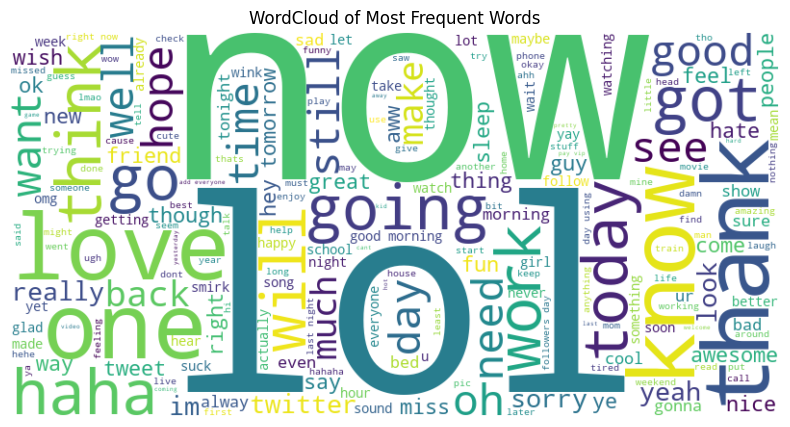

In [2]:
def plot_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color="white", relative_scaling=0).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("WordCloud of Most Frequent Words")
    plt.show()

all_text = " ".join(df_preprocessed['filtered_text'])
plot_wordcloud(all_text)

Sentiment distribution and Tweet lenght distribution

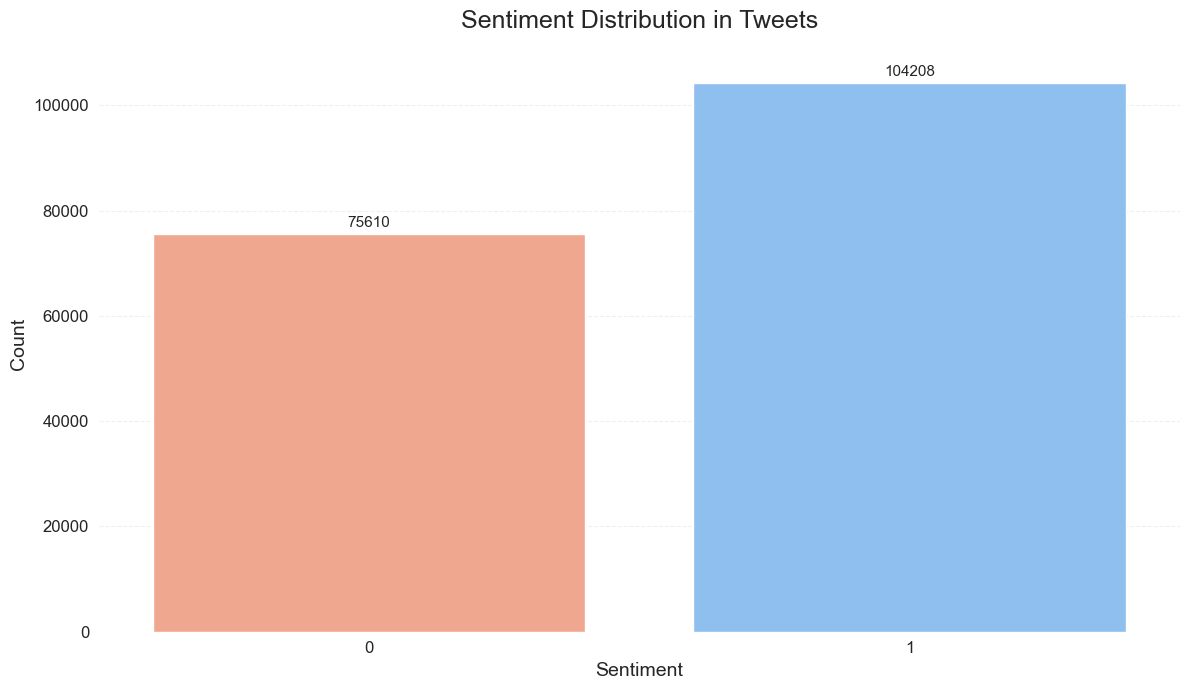

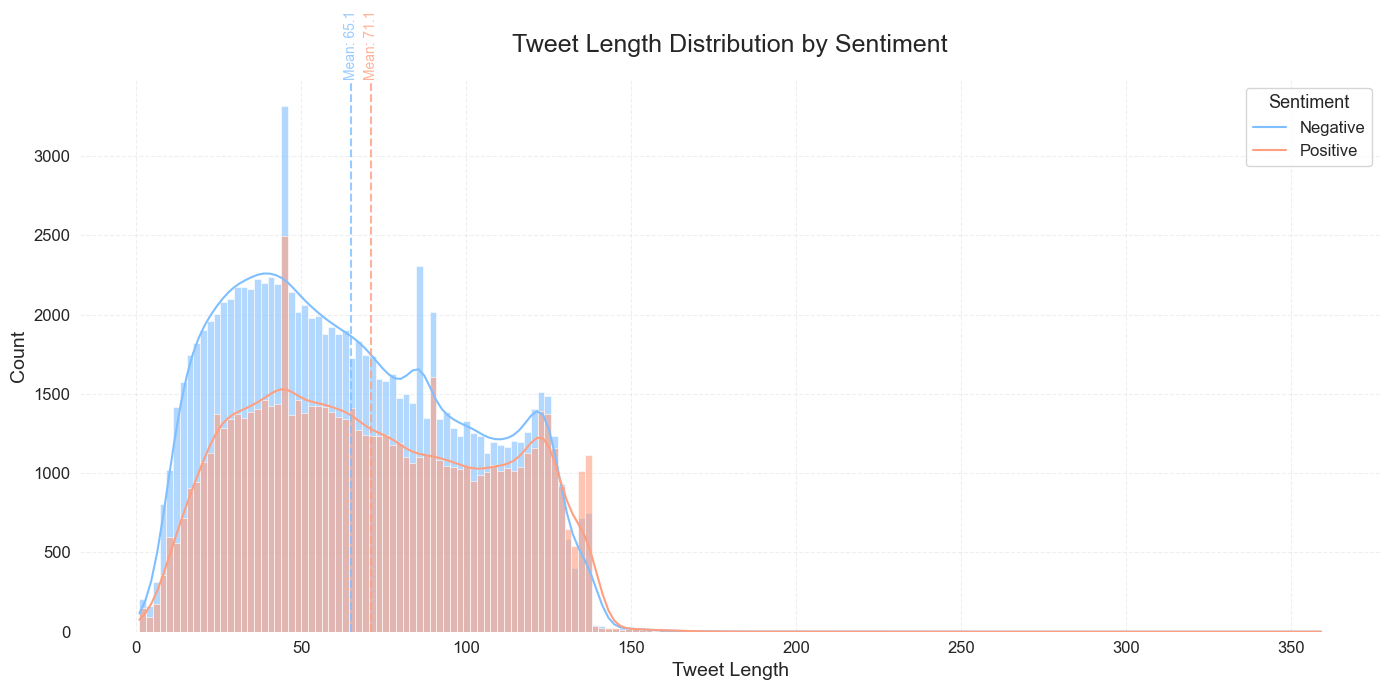

In [4]:
def set_style():
    plt.style.use('default')
    sns.set_style("whitegrid")
    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.rcParams['font.family'] = 'sans-serif'

def plot_sentiment_distribution(df):
    set_style()
    plt.figure(figsize=(12, 7))
    
    colors = ['#ff9f7f', '#7fbfff']
    ax = sns.countplot(x='sentiment', data=df, hue='sentiment', palette=colors, legend=False)
    
    plt.title('Sentiment Distribution in Tweets', fontsize=18, pad=20)
    plt.xlabel('Sentiment', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks([0, 1], ['0', '1'], fontsize=12)
    plt.yticks(fontsize=12)
    
    for i in ax.containers:
        ax.bar_label(i, fontsize=11, padding=3)

    ax.yaxis.grid(True, linestyle='--', alpha=0.3)
    
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

def plot_tweet_length_distribution(df):
    set_style()
    df['tweet_length'] = df['text'].str.len()
    
    plt.figure(figsize=(14, 7))
    
    colors = ['#ff9f7f', '#7fbfff']
    sns.histplot(data=df, x='tweet_length', hue='sentiment', kde=True, palette=colors, alpha=0.6)

    plt.title('Tweet Length Distribution by Sentiment', fontsize=18, pad=20)
    plt.xlabel('Tweet Length', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Sentiment', labels=['Negative', 'Positive'], title_fontsize='13', fontsize='12')
    plt.grid(True, linestyle='--', alpha=0.3)
    sns.despine(left=True, bottom=True)
    
    for sentiment, color in zip([0, 1], colors):
        mean_length = df[df['sentiment'] == sentiment]['tweet_length'].mean()
        if 0 <= mean_length <= 200: 
            plt.axvline(mean_length, color=color, linestyle='--', alpha=0.8)
            plt.text(mean_length, plt.gca().get_ylim()[1], f'Mean: {mean_length:.1f}',
                     horizontalalignment='center', verticalalignment='bottom',
                     fontsize=10, color=color, rotation=90, alpha=0.8)
    
    plt.tight_layout()
    plt.show()


plot_sentiment_distribution(df_preprocessed)
plot_tweet_length_distribution(df_preprocessed)

Number of tweets grouped by sentiment and divided by tweets containing links and mentions

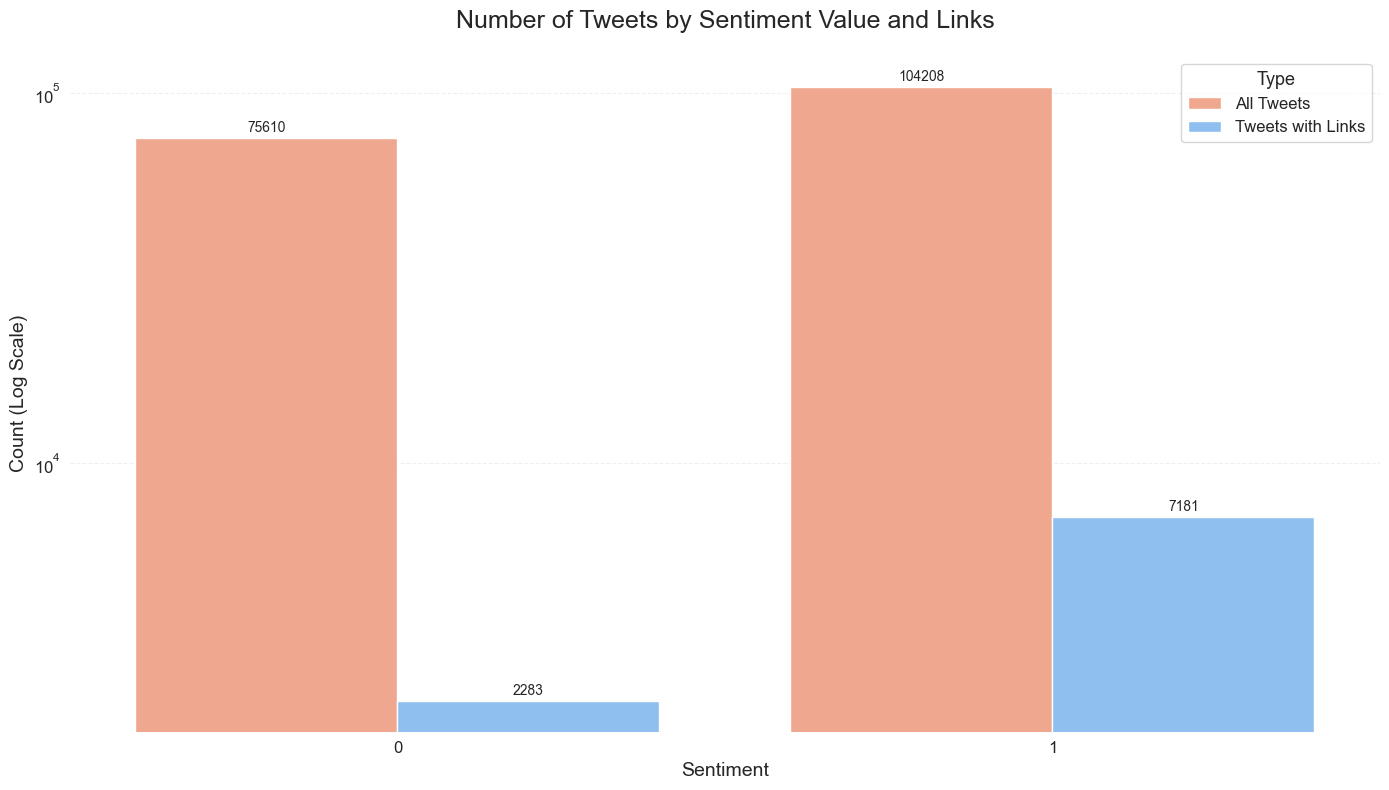

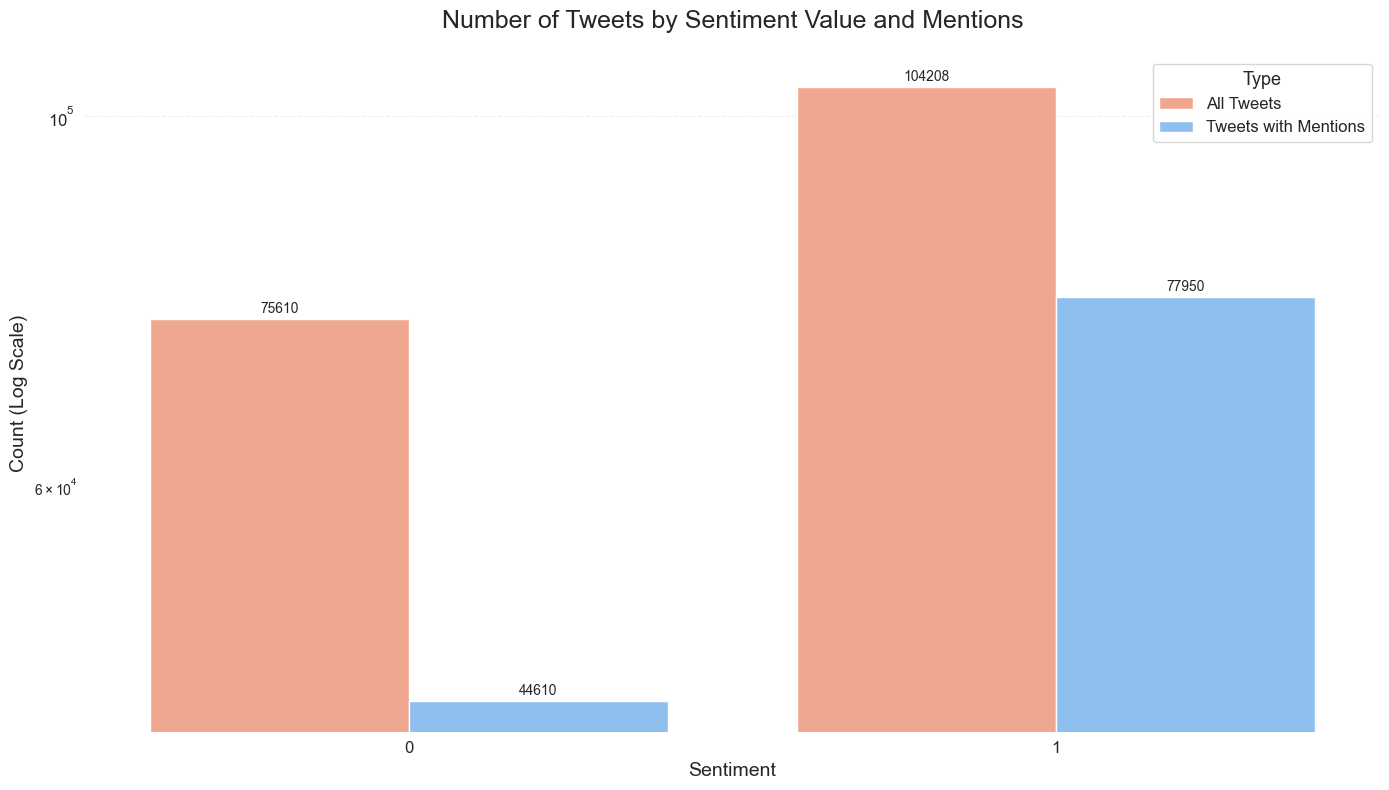

In [5]:
def set_style():
    plt.style.use('default')
    sns.set_style("whitegrid")
    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.rcParams['font.family'] = 'sans-serif'

def plot_sentiment_comparison(df, feature, feature_name):
    set_style()
    
    all_tweets = df.groupby('sentiment').size().reset_index(name='count')
    all_tweets['type'] = 'All Tweets'
    tweets_with_feature = df[df[feature] == 1].groupby('sentiment').size().reset_index(name='count')
    tweets_with_feature['type'] = f'Tweets with {feature_name}'
    
    plot_data = pd.concat([all_tweets, tweets_with_feature])
    
    plt.figure(figsize=(14, 8))
    
    colors = ['#ff9f7f', '#7fbfff']
    ax = sns.barplot(x='sentiment', y='count', hue='type', data=plot_data, palette=colors)
    
    plt.title(f"Number of Tweets by Sentiment Value and {feature_name}", fontsize=18, pad=20)
    plt.xlabel("Sentiment", fontsize=14)
    plt.ylabel("Count (Log Scale)", fontsize=14)
    plt.yscale('log')
    plt.legend(title='Type', fontsize=12, title_fontsize='13')
    
    plt.xticks([0, 1], ['0', '1'], fontsize=12)
    plt.yticks(fontsize=12)
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%.0f', label_type='edge', fontsize=10, padding=2)
    
    ax.yaxis.grid(True, linestyle='--', alpha=0.3)
    
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

plot_sentiment_comparison(df_preprocessed, 'contains_links', 'Links')
plot_sentiment_comparison(df_preprocessed, 'contains_mentions', 'Mentions')

F1 Score by varying the parameter C

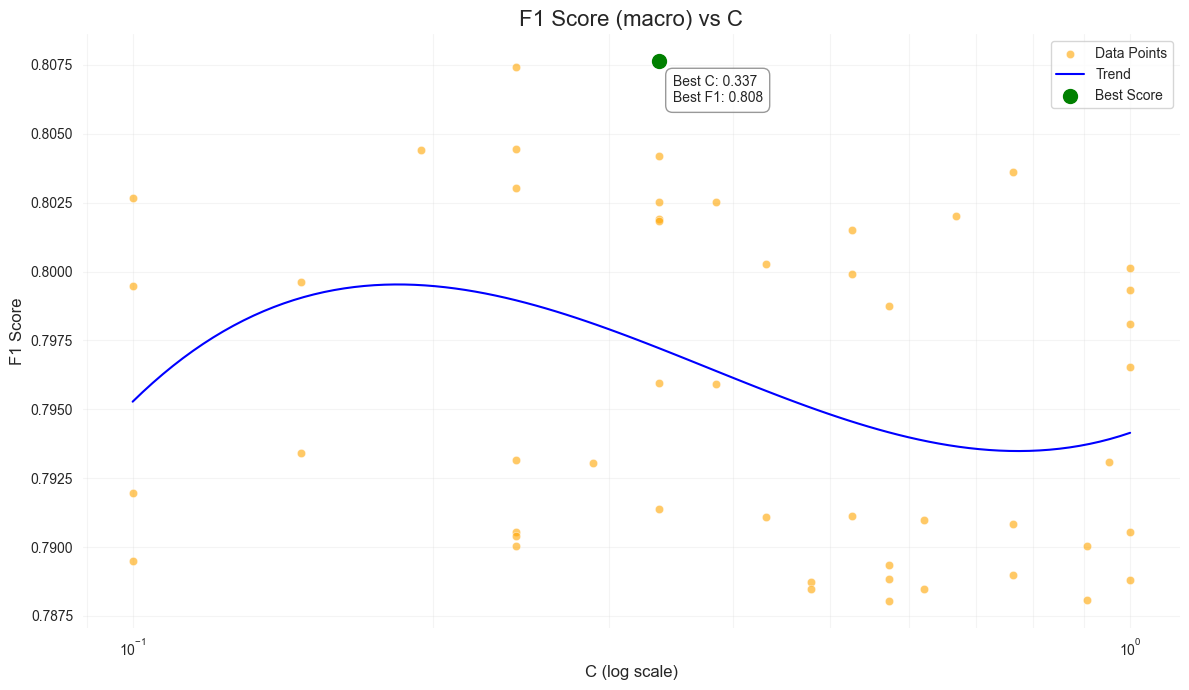

In [6]:
C_values = random_search.cv_results_['param_classifier__C'].data.astype(float)
f1_scores = random_search.cv_results_['mean_test_score']

df = pd.DataFrame({'C': C_values, 'F1 Score': f1_scores}).sort_values('C')

best_c = df.loc[df['F1 Score'].idxmax(), 'C']
best_f1 = df['F1 Score'].max()

plt.figure(figsize=(12, 7))

sns.scatterplot(x='C', y='F1 Score', data=df, alpha=0.6, color='orange', label='Data Points')

x = np.log10(df['C'])
y = df['F1 Score']
z = np.polyfit(x, y, 3)
p = np.poly1d(z)

x_smooth = np.linspace(x.min(), x.max(), 100)
y_smooth = p(x_smooth)

plt.plot(10**x_smooth, y_smooth, color='blue', label='Trend')

plt.scatter(best_c, best_f1, color='green', s=100, zorder=5, label='Best Score')

plt.xscale('log')
plt.xlabel('C (log scale)', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('F1 Score (macro) vs C', fontsize=16)

plt.annotate(f'Best C: {best_c:.3f}\nBest F1: {best_f1:.3f}',
             xy=(best_c, best_f1), xytext=(10, -10),
             textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', alpha=0.8),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.tight_layout()
plt.show()


Model performance as a function of the max_feature parameter

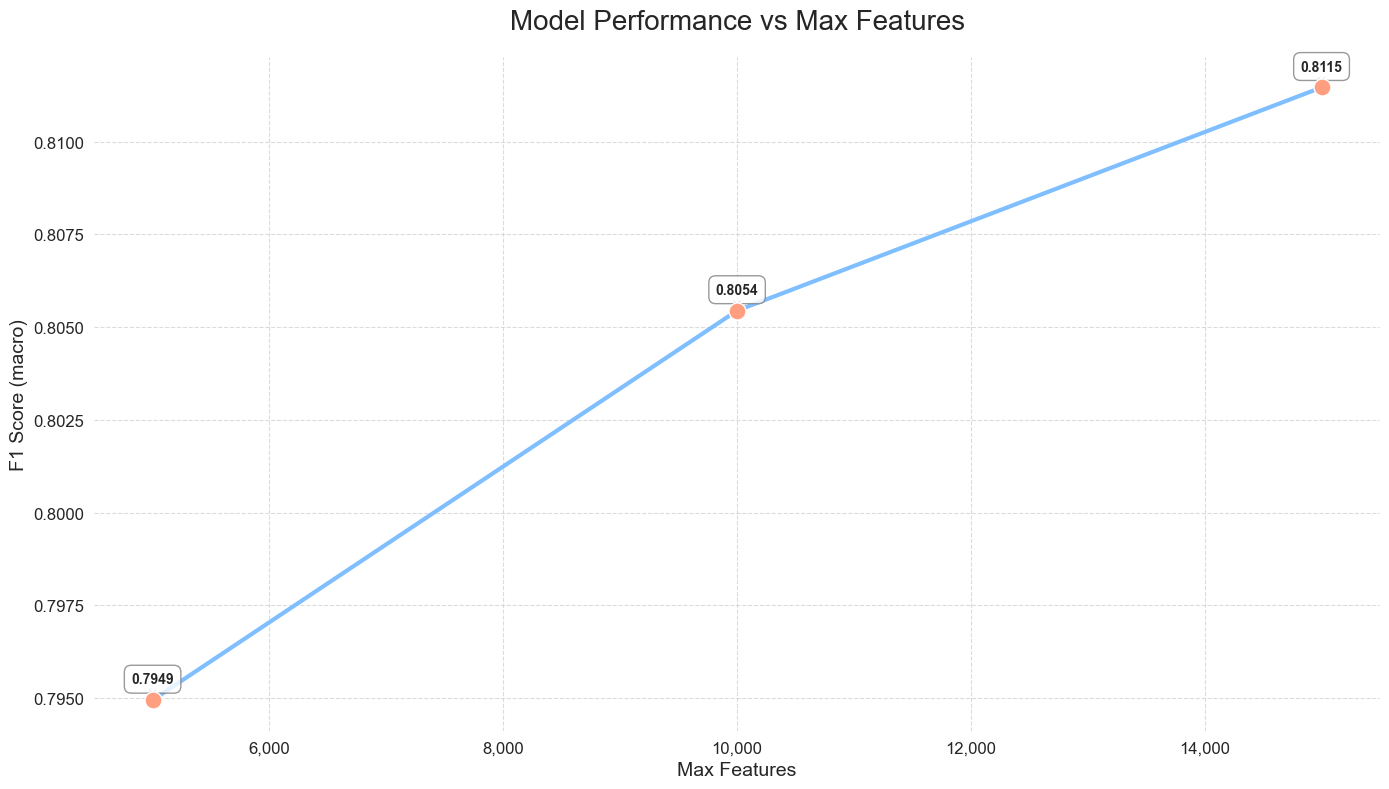

In [3]:
def set_style():
    plt.style.use('default')
    sns.set_style("whitegrid")
    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.rcParams['font.family'] = 'sans-serif'

def evaluate_max_features(random_search, X, y, max_features_range):
    set_style()
    f1_scores = []
    
    best_model = random_search.best_estimator_
    
    for max_features in max_features_range:
        features = ColumnTransformer([
            ('text', TfidfVectorizer(max_features=max_features), 'filtered_text'),
            ('additional', 'passthrough', ['contains_links', 'contains_mentions', 'hour']),
            ('day', 'passthrough', [col for col in X.columns if col.startswith('day_')])
        ])

        
        pipeline = Pipeline([
            ('features', features),
            ('classifier', best_model.named_steps['classifier']) 
        ])
        
        try:
            scores = cross_val_score(pipeline, X, y, cv=5, scoring='f1_macro')
            f1_scores.append(np.mean(scores))
        except Exception as e:
            print(f"Errore durante la cross-validation con max_features={max_features}:")
            print(str(e))
            f1_scores.append(np.nan)
    
    df = pd.DataFrame({
        'Max Features': max_features_range,
        'F1 Score': f1_scores
    })
    
    plt.figure(figsize=(14, 8))
    
    ax = sns.lineplot(x='Max Features', y='F1 Score', data=df, color='#7fbfff', 
                      marker='o', linewidth=3, markersize=10)
    
    sns.scatterplot(x='Max Features', y='F1 Score', data=df, color='#ff9f7f', 
                    s=150, ax=ax, zorder=5)
    
    plt.title('Model Performance vs Max Features', fontsize=20, pad=20)
    plt.xlabel('Max Features', fontsize=14)
    plt.ylabel('F1 Score (macro)', fontsize=14)
    
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.xticks(fontsize=12, rotation=0)
    plt.yticks(fontsize=12)
    
    for i, txt in enumerate(f1_scores):
        if not np.isnan(txt):
            ax.annotate(f'{txt:.4f}', (max_features_range[i], txt), 
                        xytext=(0, 10), textcoords='offset points', ha='center', va='bottom',
                        fontsize=10, fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', alpha=0.8),
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='gray'))
    
    ax.grid(True, linestyle='--', alpha=0.7)
    
    sns.despine(left=True, bottom=True)
    
    
    plt.tight_layout()
    plt.show()


max_features_range = [5000, 10000, 15000]
evaluate_max_features(random_search, X, y, max_features_range)

BoxPlot to represent F1 Scores for different N-gram ranges

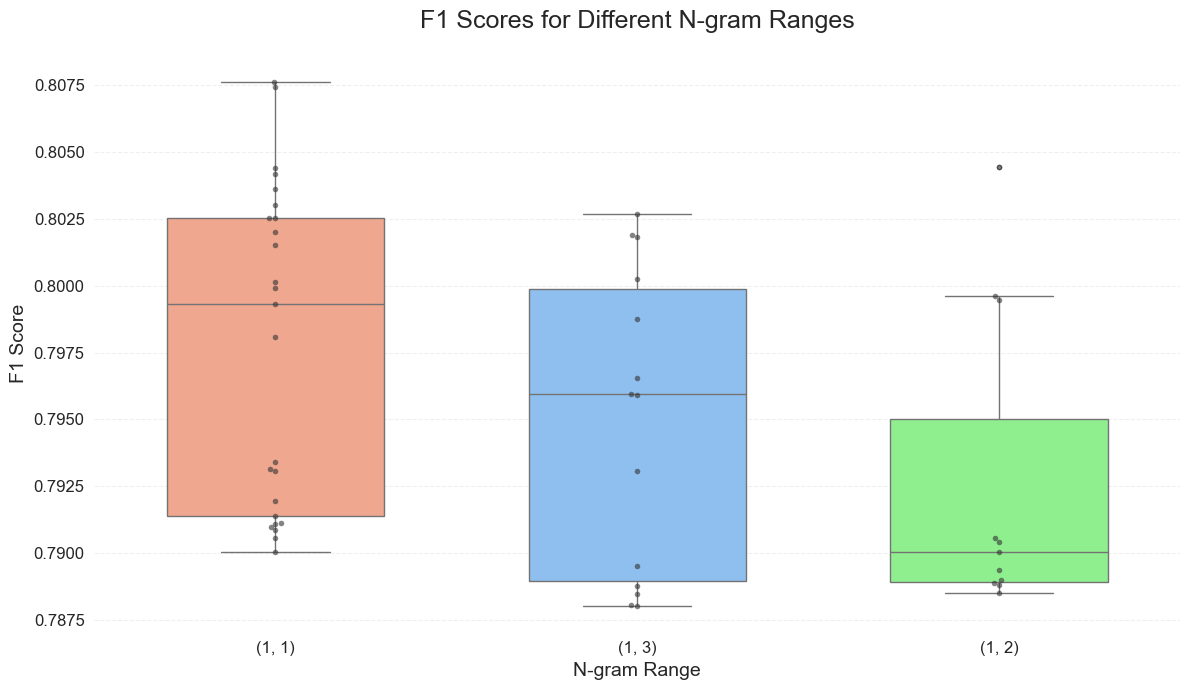

In [7]:
def plot_ngram_boxplot(random_search):
    results = pd.DataFrame(random_search.cv_results_)
    results['param_features__text__ngram_range'] = results['param_features__text__ngram_range'].astype(str)
    
    plt.figure(figsize=(12, 7))
    sns.set_style("whitegrid")
    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.rcParams['font.family'] = 'sans-serif'
    
    color_palette = ['#ff9f7f', '#7fbfff', '#7fff7f']
    
    ax = sns.boxplot(x='param_features__text__ngram_range', 
                     y='mean_test_score', 
                     data=results,
                     hue='param_features__text__ngram_range',
                     palette=color_palette,
                     width=0.6,
                     fliersize=3,
                     legend=False)

    sns.swarmplot(x='param_features__text__ngram_range', 
                  y='mean_test_score', 
                  data=results,
                  color='#333333',
                  size=4, 
                  alpha=0.6)
    
    plt.title('F1 Scores for Different N-gram Ranges', fontsize=18, pad=20)
    plt.xlabel('N-gram Range', fontsize=14)
    plt.ylabel('F1 Score', fontsize=14)
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)
    
    ax.yaxis.grid(True, linestyle='--', alpha=0.3)
    
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

plot_ngram_boxplot(random_search)